###Assignment

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

import tensorflow as tf
import re


##Data Visualization

In [3]:
df_train=pd.read_csv('/content/drive/MyDrive/StumbleUpon/train.tsv',sep='\t')

In [4]:
df_test_main=pd.read_csv('/content/drive/MyDrive/StumbleUpon/test.tsv',sep='\t',usecols=['urlid','boilerplate'])

In [ ]:
df_train.columns

Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label'],
      dtype='object')

In [ ]:
df_train.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [ ]:
df_train['alchemy_category'].value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64

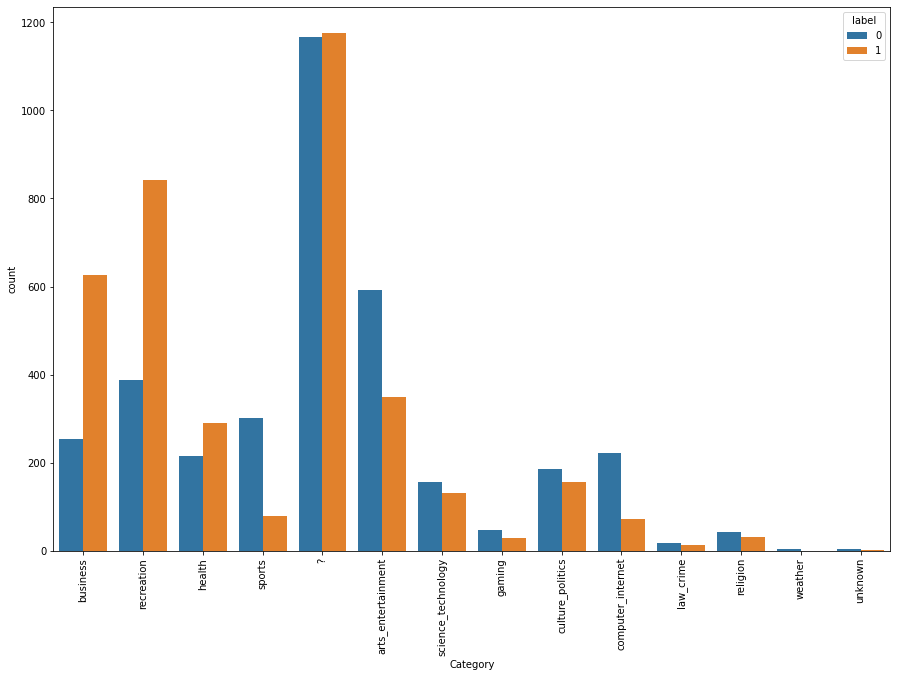

In [5]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_train['alchemy_category'],hue=df_train['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

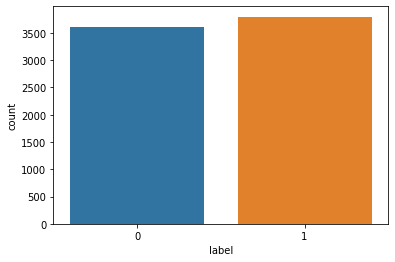

In [6]:
sns.countplot(x=df_train['label'])

##Data Pre-processing and cleaning

In [9]:
def clean_text(
    string: str, 
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=['the', 'a', 'and', 'is', 'be', 'will']) -> str:
    """
    A method to clean text 
    """
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string 

In [8]:
df_train['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_train['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_test_main['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_test_main['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)


In [10]:
for i in range(0,len(df_train['boilerplate'])):
  df_train['boilerplate'][i] = clean_text(df_train['boilerplate'][i])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
for i in range(0,len(df_test_main['boilerplate'])):
  df_test_main['boilerplate'][i] = clean_text(df_test_main['boilerplate'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##Train Test Split

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_train['boilerplate'], df_train['label'], test_size=0.3, random_state=4
)

##Model Training

In [12]:
from gensim.models import Word2Vec
import time
import numpy as np
# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

word2vec_model_file = '/content/drive/MyDrive/StumbleUpon/Model' + 'word2vec_' + str(size) + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(df_train['boilerplate']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 156.1536509990692


In [14]:
# Load the model from the model file
sg_w2v_model = Word2Vec.load('/content/drive/MyDrive/StumbleUpon/Model/Modelword2vec_1000.model')

##Saving word embeddings

In [15]:
word2vec_filename = '/content/drive/MyDrive/StumbleUpon/Embeddings' + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.to_frame().iterrows():
        model_vector = (np.mean([sg_w2v_model[token] for token in row['boilerplate']], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


## Fitting the Model

In [16]:
import time
#Import the DecisionTreeeClassifier
from sklearn.tree import DecisionTreeClassifier
# Load from the filename
word2vec_df = pd.read_csv('/content/drive/MyDrive/StumbleUpon/Embeddings/Embeddingstrain_review_word2vec.csv')
#Initialize the model
clf_decision_word2vec = DecisionTreeClassifier()

start_time = time.time()
# Fit the model
clf_decision_word2vec.fit(word2vec_df, Y_train)
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the model with word2vec vectors: 6.19443941116333


##Calculating Accuracy

In [17]:
from sklearn.metrics import classification_report
test_features_word2vec = []
for index, row in X_test.to_frame().iterrows():
    model_vector = np.mean([sg_w2v_model[token] for token in row['boilerplate']], axis=0)
    if type(model_vector) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(1000)]))
test_predictions_word2vec = clf_decision_word2vec.predict(test_features_word2vec)
print(classification_report(Y_test,test_predictions_word2vec))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1093
           1       0.00      0.00      0.00      1126

    accuracy                           0.49      2219
   macro avg       0.25      0.50      0.33      2219
weighted avg       0.24      0.49      0.33      2219



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Final Prediction

In [25]:
test_features_word2vec = []
for index, row in df_test_main.iterrows():
    model_vector = np.mean([sg_w2v_model[token] for token in row['boilerplate']], axis=0)
    if type(model_vector.tolist()) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(1000)]))
test_predictions_word2vec = clf_decision_word2vec.predict(test_features_word2vec)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
